<a href="https://colab.research.google.com/github/imrealhelper/Linear-Algebra/blob/main/soft_ware_labs/ase3001_rocket_guidance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rocket guidance
$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> ASE3001: Computational Experiments for Aerospace Engineering, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_

<br>

이전 예제에서 다루었던 자유비행 로켓의 궤적 분산 시뮬레이션에 이어서, 이번에는 로켓에 유도기능을 추가하여 원하는 표적으로 로켓을 보내기 위한 로켓 유도문제를 다룬다. 비행체를 원하는 목표점으로 이동시키기 위해 기동가속도를 발생시켜 경로를 수정하는 것은 유도(guidance)라 하며, 유도 알고리듬은 항법장치와 센서 등으로부터 가용한 정보들을 활용하여 비행체를 목표점으로 이동시키기 위한 적절한 기동가속도를 주기적으로 계산하는 역할을 한다. 요구된 기동가속도는 비행체의 받음각/옆미끄러짐각 등을 통해 발생된 양력 등의 수직력을 통해 만들어질 수 있다.  


<br>

---

우선 자유비행 로켓의 운동모델과 바람의 효과를 반영한 시뮬레이션을 다시 살펴보자.

로켓의 속도 벡터 방향을 설명하는 상태변수인 속도 $V$, 수직방향 비행 경로각 $\gamma$와 수평방향 헤딩각 $\psi$에 대한 동역학은 다음과 같다. 수직방향 비행경로각은 수평으로 비행하는 경우 0도로 정의되며, 상승하는 경우 비행 경로각이 증가하여 수직 상승 비행하는 경우를 90도로 정의한다. 수평방향 헤딩각은 정북 방향으로 비행하는 경우 0도로 정의되며, 오른쪽으로 선회하면 헤딩각이 증가하여 정동 방향으로 비행하는 경우를 90도로 정의한다.

\begin{align*}
  m\dot{V} &= D_x - mg\sin\gamma \\
  mV\dot{\gamma} &= -D_z -mg\cos\gamma \\
  mV\dot{\psi} &= D_y \\
\end{align*}

<center>
<img src="https://jonghank.github.io/ase3001/files/frame.png" width="600">
</center>

여기서 $m$은 로켓의 질량이며, 항력 $D=(D_x, D_y, D_z)\in\R^3$는 각각 항력의 1) 진행방향 성분($D_x$), 2) 진행방향에 수직인 오른쪽 수평방향 성분($D_y$), 3) 진행방향에 수직인 아랫쪽 수직방향 성분($D_z$)이다. 일반적으로 자유비행하는 로켓의 정적 안정성은 확보되어 있어, 항상 받음각 0도를 유지하므로 양력은 없다고 가정할 수 있다.

로켓의 위치는 발사 원점을 기준으로, 북쪽(N)/동쪽(E) 방향의 이동거리와 고도(H) 방향의 이동거리를 나타내는 $p=(p_n, p_e, h)\in\R^3$로 표현한다. 참고로 고도 방향(H)은 중력이 작용하는 하강 방향(D)의 반대 방향이다. 위치를 나타내는 변수 $p_n, p_e, h$의 변화율은 아래의 동역학에 의해 표현되며, 각각의 우변은 속도벡터의 NEH 성분 (북쪽방향 $v_n$, 동쪽방향 $v_e$, 고도방향 $\dot{h}=-v_d$)을 상태변수 $V,\gamma,\psi$를 이용해 표현한 것으로 볼 수 있다.

\begin{align*}
  \dot{p}_n &= v_n = V\cos\gamma\cos\psi \\
  \dot{p}_e &= v_e = V\cos\gamma\sin\psi \\
  \dot{h} &= - v_d = V\sin\gamma
\end{align*}

위에 설명된 여섯 개의 상태변수로 로켓 궤적을 기술하는 동역학을 표현할 수 있으며, 이제 매 순간의 진행 방향과 수직 방향의 항력 성분 $D=(D_x, D_y, D_z)$가 주어지기만 하면 여섯 개 변수의 시간변화율을 계산하고 시간에 대해 적분할 수 있다.


항력의 크기는 아래와 같이 동압(dynamic pressure)에 비례하며, 동압은 고도의 함수로 모델링될 수 있는 대기 밀도에 비례하고, 바람에 대한 상대속도의 제곱에 비례하는 것으로 모델링할 수 있다.
항력 방향은 바람에 대한 상대속도의 반대방향이 되며, 파라미터 $C_d$와 $S$는 로켓의 항력계수와 단면적으로, 변하지 않는 상수로 가정한다.
이를 종합하면 NED 방향 항력 성분 $D_{ned}=(D_n, D_e, D_d)$을 아래와 같이 계산할 수 있다.

\begin{align*}
  D_{ned} = \bmat{D_n \\ D_e \\ D_d} &=
  \overbrace{\overbrace{\frac{1}{2}\rho \|v_\text{rel} \|^2}^{\text{동압}}SC_D}^{\text{항력크기}}
  \overbrace{\left(-\frac{v_\text{rel}}{\|v_\text{rel} \|}\right)}^{\text{항력방향}} \\
  &= -\frac{1}{2}\rho SC_D \|v_\text{rel} \| v_\text{rel}
\end{align*}

대기 밀도는 아래와 같이 고도의 함수로 모델링할 수 있다. 밀도의 단위는 $\text{kg/m}^3$, 고도의 단위는 $\text{m}$이다,

\begin{align*}
  \rho(h) &= 1.225 \left(1-2.256\times 10^{-5}h \right)^{5.256}
\end{align*}

바람에 대한 로켓의 상대속도($v_\text{rel}\in\R^3$)는 NED 좌표계에서 아래와 같이 표현할 수 있다.

\begin{align*}
  v_\text{rel} &= v_{ned}- v_{w} \\
  &= \bmat{V\cos\gamma\cos\psi \\ V\cos\gamma\sin\psi \\ -V\sin\gamma} - \bmat{v_{w,n} \\ v_{w,e} \\ v_{w,d}}
\end{align*}

<br>

이렇게 계산된 NED 좌표계에서의 항력 성분 $D_{ned}=(D_n, D_e, D_d)$을 회전변환을 통해 진행방향 좌표계에서의 항력 성분 $D_{xyz}=(D_x, D_y, D_z)$로 변환할 수 있으며, 이 값들을 매 순간 상태변수를 통해 계산함으로써 동역학 적분이 수행된다.  

\begin{align*}
  D_{xyz} = \bmat{D_x \\ D_y \\ D_z} = \bmat{\cos\gamma\cos\psi & \cos\gamma\sin\psi & -\sin\gamma \\
  -\sin\psi & \cos\psi & 0 \\  
  \sin\gamma\cos\psi & \sin\gamma\sin\psi & \cos\gamma } D_{ned}
\end{align*}


<br>

주요 상수들은 다음과 같이 설정한다.

- $m$: 로켓의 질량 (=$40\,\text{kg}$)
- $d$: 로켓의 직경 (=$0.16\,\text{m}$)
- $S$: 로켓의 단면적 (=$\pi d^2/4$)
- $C_D$: 로켓의 항력계수 (=$0.2$)
- $g$: 중력가속도 (=$9.8\,\text{m/s}^2$)




In [1]:
import numpy as np
import matplotlib.pyplot as plt

# parameters
m = 40               # mass
S = np.pi*0.08**2    # cross-section area
Cd = 0.2             # drag coefficient
g = 9.8              # gravitational acceleration

# unit conversion
Rad2Deg = 180/np.pi  # conversion: radian to degree
Deg2Rad = 1/Rad2Deg  # conversion: degree to radian


<br>

바람은 수평으로만 분다고 가정하여, $h$방향 또는 $d$ 방향의 성분은 0이다. 즉, NED 좌표계에서 바람의 속도를 표현하면 $v_w = (v_{w,n},  v_{w,e}, 0)$이다.

- 발사 초기 $k=0$에서 바람의 속도 $v_{w,n}$과 , $v_{w,e}$는 평균이 0이고 표준편차가 5인 정규분포를 따르며, $v_{w,d}=0$는 0으로 설정한다.
- 바람의 속도 변화에 random walk를 적용한다. 즉, 모든 스텝 $k$에서 $v_w$는 아래와 같이 랜덤하게 변화한다. $r_n$과 $r_e$는 모두 평균이 0이고 표준편차가 1인 정규분포를 따르며, 모든 스텝마다 독립적으로 발생된다.

\begin{align*}
  v_{w,n} &= v_{w,n} + r_{n} \\
  v_{w,e} &= v_{w,e} + r_{e}
\end{align*}

<br>

---

위와 같은 모델링을 구현하고 시뮬레이션을 수행하면 아래와 같은 결과를 얻을 수 있다. 시뮬레이션을 수행할 때 마다 랜덤한 바람에 의해 다른 궤적이 얻어짐을 확인하시오.

In [2]:
def state_derivative(z,v_w):
  V, gamma, psi, pn, pe, h = z

  rho = 1.225*(1-2.256e-5*h)**5.256

  c_gam, s_gam = np.cos(gamma), np.sin(gamma)
  c_psi, s_psi = np.cos(psi),   np.sin(psi)

  vn = V*c_gam*c_psi
  ve = V*c_gam*s_psi
  vd = -V*s_gam
  v_ned = np.array([vn, ve, vd])

  v_rel = v_ned - v_w
  v_mag = np.sqrt(v_rel.dot(v_rel))
  D_ned = -0.5*rho*S*Cd*v_mag*v_rel

  C_ned_to_xyz = np.array([[c_gam*c_psi,  c_gam*s_psi, -s_gam],
                           [     -s_psi,        c_psi,      0],
                           [s_gam*c_psi,  s_gam*s_psi,  c_gam]])
  D_xyz = C_ned_to_xyz.dot(D_ned)

  V_dot     =  D_xyz[0]/m   - g*s_gam
  gamma_dot = -D_xyz[2]/m/V - g*c_gam/V
  psi_dot   =  D_xyz[1]/m/V
  pn_dot = vn
  pe_dot = ve
  h_dot = -vd

  return np.array([V_dot, gamma_dot, psi_dot, pn_dot, pe_dot, h_dot])

In [4]:
# integration parameters
tf = 200                  # final time
dt = 0.1                  # step size
t = np.arange(0, tf, dt)  # time (tentative)
N = len(t)                # number of time steps

# initial conditions
V = 1000.0                # velocity
gamma = 40*Deg2Rad        # flight path angle
psi = 90*Deg2Rad          # heading
pn, pe, h = np.zeros(3)   # position
init = [V, gamma, psi, pn, pe, h]

In [5]:
# initialize time
t = np.arange(0, tf, dt)  # time (tentative)
N = len(t)                # number of time steps

# initial wind
v_w = 5*np.random.randn(3)
v_w[-1] = 0

# numerical integration
state = np.zeros((N,len(init)))
state[0] = init
deriv_p = state_derivative(state[0],v_w)
for k in range(N-1):
  deriv = state_derivative(state[k],v_w)
  state[k+1] = state[k] + dt*(3*deriv - deriv_p)/2
  v_w[0] += np.random.randn()
  v_w[1] += np.random.randn()
  deriv_p = deriv
  if state[k,-1]<0:       # termination condition
    break;                # break if the last state variable (h) is negative

# solution
t_s = t[:k+1]             # time
state = state[:k+1]       # state history

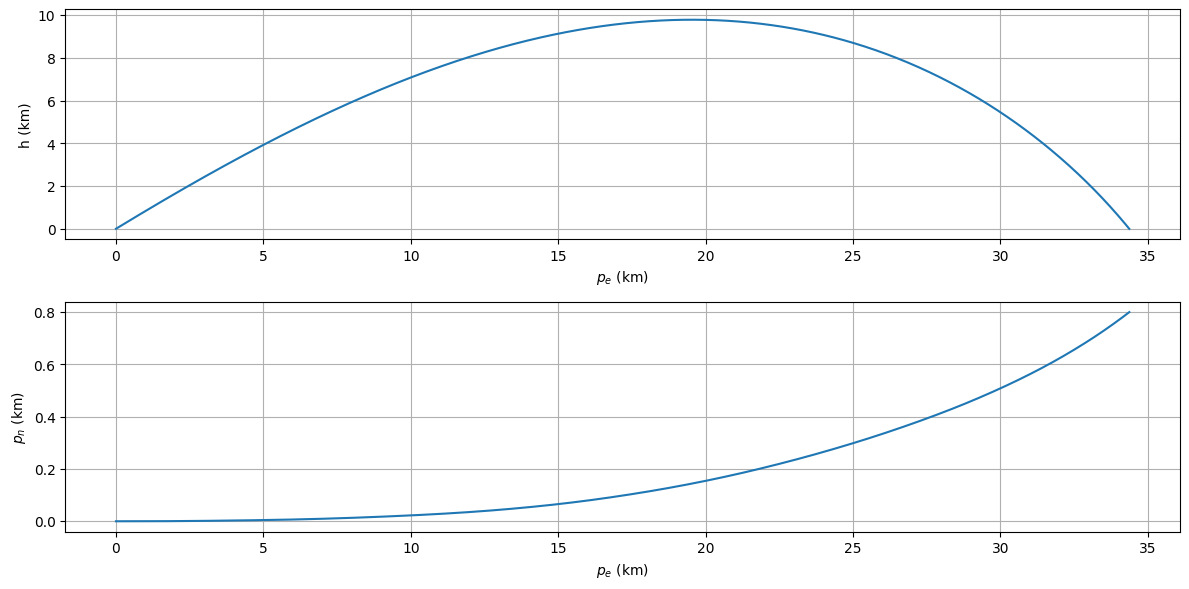

종말 속도: 390.12 m/s
종말 비행 경로각: -59.30 deg
비행거리: 34.37 km


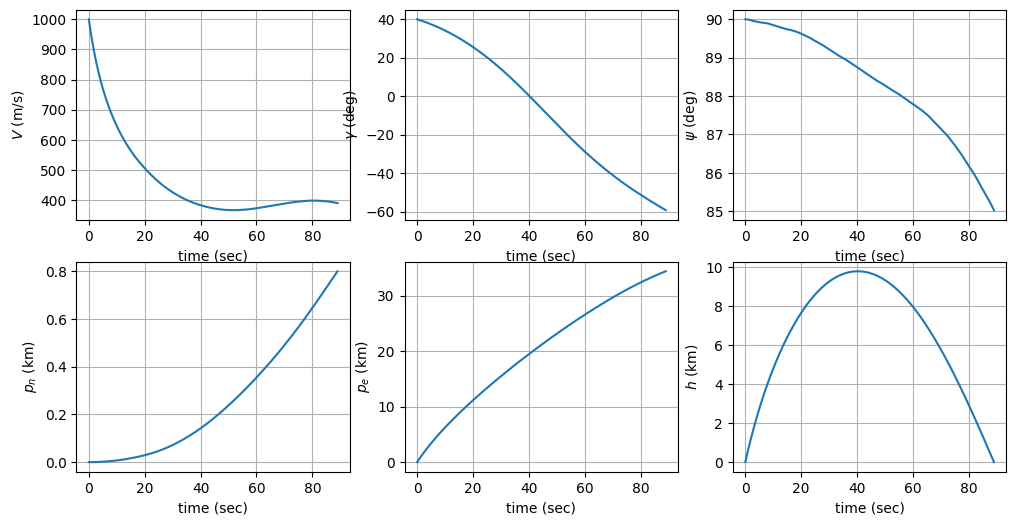

In [6]:
# plot
fig, ax = plt.subplots(2,1, figsize=(12,6), dpi=100)
ax[0].plot(state[:,4]/1000, state[:,5]/1000)
ax[0].set_xlabel(r'$p_e$ (km)')
ax[0].set_ylabel(r'h (km)')
ax[0].grid()
ax[1].plot(state[:,4]/1000, state[:,3]/1000)
ax[1].set_xlabel(r'$p_e$ (km)')
ax[1].set_ylabel(r'$p_n$ (km)')
ax[1].grid()
plt.tight_layout()
plt.show()

print(f'종말 속도: {state[-1,0]:.2f} m/s')
print(f'종말 비행 경로각: {state[-1,1]*Rad2Deg:.2f} deg')
print(f'비행거리: {state[-1,4]/1000:.2f} km')

plt.figure(figsize=(12,6), dpi=100)
plt.subplot(2,3,1)
plt.plot(t_s, state[:,0])
plt.xlabel(r'time (sec)')
plt.ylabel(r'$V$ (m/s)')
plt.grid()
plt.subplot(2,3,2)
plt.plot(t_s, state[:,1]*180/np.pi)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$\gamma$ (deg)')
plt.grid()
plt.subplot(2,3,3)
plt.plot(t_s, state[:,2]*180/np.pi)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$\psi$ (deg)')
plt.grid()
plt.subplot(2,3,4)
plt.plot(t_s, state[:,3]/1000)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$p_n$ (km)')
plt.grid()
plt.subplot(2,3,5)
plt.plot(t_s, state[:,4]/1000)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$p_e$ (km)')
plt.grid()
plt.subplot(2,3,6)
plt.plot(t_s, state[:,5]/1000)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$h$ (km)')
plt.grid()
plt.show()

<br>

---

이제 유도기능이 포함된 유도로켓의 모델링을 살펴보자. 유도기능이 반영되지 않았던 자유비행로켓의 모델링과 아래의 두 가지가 달라짐을 잘 이해하기 바람.

- 유도컴퓨터에 의해 계산된 기동가속도 $u_z$와 $u_y$는 각각 수직방향과 수평방향의 경로를 수정하는 역할을 하며, 실제로는 비행제어기에 의한 조종날개 조작으로 발생된다. 여기서는 이상적인 비행제어기를 가정해서 유도컴퓨터에서 명령이 발생된 즉시 기동가속도가 발생된다고 가정한다. 이에 대한 모델링은 아래와 같이 반영될 수 있다.  

\begin{align*}
  m\dot{V} &= D_x - mg\sin\gamma \\
  mV\dot{\gamma} &= -D_z -mg\cos\gamma - m u_z \\
  mV\dot{\psi} &= D_y + m u_y
\end{align*}

- 유도를 위한 기동가속도는 받음각과 옆미끄러짐각에 의해 발생되므로, 비행체의 항력계수($C_D$) 는 아래와 같이 이 둘의 함수가 된다. 기동력이 크게 발생할수록 항력은 증가하게 된다. 여기에서, $C_{D,0}$는 받음각 0도에서의 프로파일 항력계수이며, $k_i$는 기동력에 의해 더해지는 항력의 크기를 표현하는 유도항력 계수, $C_{L,\alpha}=\partial{C_L}/\partial{\alpha}$는 양력계수 기울기를 의미한다. $u_z$와 $u_y$의 단위는 $\text{m}/\text{s}^2$이다.  

$$
C_D = C_{D,0} + k_i \frac{4m^2 }{\rho^2 \|v_\text{rel}\|^4 S^2 C^4_{L,\alpha}} \left(u_z^2 + u_y^2\right)
$$


<br>

주요 상수들과 새롭게 정의된 상수들을 정리하면 다음과 같다.

- $m$: 로켓의 질량 (=$40\,\text{kg}$)
- $d$: 로켓의 직경 (=$0.16\,\text{m}$)
- $S$: 로켓의 단면적 (=$\pi d^2/4$)
- $g$: 중력가속도 (=$9.8\,\text{m/s}^2$)
- $k_i$: 유도항력 계수 (=$5$)
- $C_{D,0}$: 프로파일 항력계수 (=$0.2$)
- $C_{L,\alpha}$: 양력계수 기울기 (=$8$)


In [73]:
import numpy as np
import matplotlib.pyplot as plt

# parameters
m = 40               # mass
S = np.pi*0.08**2    # cross-section area
g = 9.8              # gravitational acceleration
ki = 5               # induced drag coefficient
Cd0 = 0.2            # profile drag coefficient
Cla = 8              # lift curve slope

# unit conversion
Rad2Deg = 180/np.pi  # conversion: radian to degree
Deg2Rad = 1/Rad2Deg  # conversion: degree to radian

<br>

---

<br>

_**(Problem 1)**_
위의 문제에서와 동일한 상태변수 정의와 바람 모델링을 사용하고, 유도 기능이 고려된 로켓의 궤적을 계산하기 위해 상태변수 $z_t$와 바람속도 $v_w$, 유도명령 $u_t=(u_{t,z}, u_{t,y})$를 입력받아 상태변수 시간변화율 $\dot{z}_t$를 출력하는 `state_derivative` 함수를 정의하시오. 위에서 정의했던 함수를 대부분 재사용하고, 수정한 부분을 명확히 표시하시오.

In [87]:
def state_derivative(z,v_w,u):
  V, gamma, psi, pn, pe, h = z
  rho = 1.225*(1-2.256e-5*h)**5.256
  c_gam, s_gam = np.cos(gamma), np.sin(gamma)
  c_psi, s_psi = np.cos(psi),   np.sin(psi)
  vn = V*c_gam*c_psi
  ve = V*c_gam*s_psi
  vd = -V*s_gam
  v_ned = np.array([vn, ve, vd])
  v_rel = v_ned - v_w
  v_mag = np.sqrt(v_rel.dot(v_rel))
  Cd = Cd0 + ki * (4 * m**2 / (rho**2 * S**2 * Cla**4)) * (u[0]**2 + u[1]**2) / v_mag**4
  D_ned = -0.5*rho*S*Cd*v_mag*v_rel
  C_ned_to_xyz = np.array([[c_gam*c_psi,  c_gam*s_psi, -s_gam],
                           [     -s_psi,        c_psi,      0],
                           [s_gam*c_psi,  s_gam*s_psi,  c_gam]])
  D_xyz = C_ned_to_xyz.dot(D_ned)
  V_dot    =  D_xyz[0]/m   - g*s_gam
  gamma_dot = -D_xyz[2]/(m*V) - g*c_gam/V -u[0]/V
  psi_dot   =  D_xyz[1]/(m*V) + u[1]/V
  pn_dot = vn
  pe_dot = ve
  h_dot = -vd


  ##################
  # your code here #


  # your code here #
  ##################

  return np.array([V_dot, gamma_dot, psi_dot, pn_dot, pe_dot, h_dot])

<br>

실제 유도로켓의 유도알고리듬으로 가장 널리 사용되는 비례항법(PN, Proportional Navigation) 유도는, 표적이 항상 같은 방향에 보이도록 접근하면 항상 표적과 충돌할 수 있다는 원리에 기반한다.
비례항법 유도는 비행체 시스템과 가용 센서 등에 따라 여러 가지 방법으로 구현될 수 있지만, 여기에서는 아래와 같이 가장 간단한 방법을 소개한다.

절대 좌표계에서 나를 기준으로 한 표적의 상대 위치와 상대 속도를 정의하면 다음과 같다. 여기서 $p_\text{m}$과 $v_\text{m}$은 각각 유도로켓의 (NED 좌표계에서의) 위치와 속도를 의미하며, $p_\text{t}$와 $v_\text{t}$는 표적의 위치와 속도를 의미한다. 고정 표적의 경우는 $v_\text{t}=0$이다.

\begin{align*}
p_\text{r} &= p_\text{m} - p_\text{t} \\
v_\text{r} &= v_\text{m} - v_\text{t}
\end{align*}

표적이 보이는 방향을 의미하는 시선각 (LOS, Line of Sight) 벡터 $\lambda$는 상대위치 벡터와 같으며,

\begin{align*}
\lambda &= p_\text{r}
\end{align*}

이 시선각 벡터의 변화율($\Omega$)은 상대위치 및 상대속도 벡터와 아래의 관계를 갖는다.  

\begin{align*}
  v_\text{r} &= \Omega \times p_\text{r}
\end{align*}

양 변을 $p_\text{r}$와 cross-product 하여 정리하면 아래와 같고,

\begin{align*}
  p_\text{r} \times v_\text{r} &= p_\text{r}\times \left(\Omega \times p_\text{r}\right) \\
  &= \Omega \left(p_\text{r}^T p_\text{r}\right) - p_\text{r}\left(p_\text{r}^T\Omega\right)
\end{align*}

상대위치와 시선각 변화율 벡터는 서로 수직이므로, 시선각 변화율 벡터를 다음과 같이 얻을 수 있다.

\begin{align*}
  \Omega &=  \frac{p_\text{r} \times v_\text{r}}{\|p_\text{r}\|^2}
\end{align*}

비례항법 유도는 기동가속도 명령을 위의 시선각 변화율에 비례하도록 생성하며,

\begin{align*}
  a_\text{cmd} &= 3 v_\text{r} \times \Omega
\end{align*}

위의 기동가속도 명령의 $z$축과 $y$축 성분이 $u_z$와 $u_y$가 된다.

기체 $y$축 방향 $e_y$는 중력 방향과 $v_\text{m}$의 cross-product 방향이므로 아래와 같이 얻을 수 있으며,

\begin{align*}
  \tilde{e}_y &= \bmat{0 \\ 0 \\ 1} \times v_\text{m} \\
  e_y &= \tilde{e}_y/ \|\tilde{e}_y\|
\end{align*}

기체 $z$축 방향, $e_z$는 $v_\text{m}$ 방향과 $e_y$의 cross-product 방향이므로 아래와 같이 얻을 수 있다.

\begin{align*}
  \tilde{e}_z &= v_\text{m} \times e_y \\
  e_z &= \tilde{e}_z/ \|\tilde{e}_z\|
\end{align*}

마지막으로, 이들을 활용하여 기동가속도 명령의 $z$축과 $y$축 성분을 아래와 같이 계산할 수 있다. $z$축 방향으로는 $+g\cos\gamma$만큼의 중력이 작용하므로 $z$방향 기동가속도에 $-g\cos\gamma$를 미리 더함으로써 중력에 의한 효과를 보상하였다.

\begin{align*}
  u_z &= e_z^T a_\text{cmd} -g\cos\gamma\\
  u_y &= e_y^T a_\text{cmd}
\end{align*}

그런데, 로켓의 기동가속도는 양력 등의 수직력(normal force)에 의해 발생하므로, 모든 로켓은 생성 가능한 기동가속도에 한계가 존재하고, 이 한계를 넘는 기동가속도를 발생시키도록 유도명령을 생성해서는 안된다. 이 한계 기동가속도를 $u_\text{max}$라 하자. 만약 $u=\bmat{u_z^T & u_y^T}^T$의 크기가 $u_\text{max}$를 초과하는 경우에는 아래와 같은 방법으로 기동가속도의 크기가 $u_\text{max}$가 되도록 제한하는 방법을 사용할 수 있다.

\begin{align*}
  u_z &= u_z \frac{u_\text{max}}{\sqrt{u_z^2+u_y^2}} \\
  u_y &= u_y \frac{u_\text{max}}{\sqrt{u_z^2+u_y^2}}
\end{align*}

마지막으로, 발사 초기에는 발사 충격, 초기 외란 등과 발사장 안전성 등을 고려하여 발사 직후부터 유도를 수행하지는 않고 일정 시간동안은 자유비행을 하도록 두는 것이 일반적이다. 그리고, 표적에 도달하기 직전에는 일반적으로 큰 시선각 변화율이 발생할 수 있으므로 표적에 도달하기 직전에도 유도를 수행하지 않는 것이 일반적이다.

발사 후 $t_\text{start}$가 지나기 전에는 아래와 같이 자유비행하도록 하고,
\begin{align*}
  u &= \bmat{u_z \\ u_y} = \bmat{0 \\ 0} \qquad \text{ if } t< t_\text{start}
\end{align*}

잔여 비행시간이 $t_\text{cutoff}$ 이하가 되면 $a_\text{cmd}=0$으로 유도를 종료하는 것으로 하자.

\begin{align*}
  u &= \bmat{u_z \\ u_y} = \bmat{-g\cos\gamma \\ 0} \qquad \text{ if } t_\text{go}< t_\text{cutoff}
\end{align*}

잔여 비행시간($t_\text{go}$)은 아래와 같이 간단한 방법으로 추산하기로 한다.

$$
  t_\text{go} = \frac{\|p_\text{r}\|}{\|v_\text{r}\|}
$$

<br>

- $t_\text{start}$: 초기 자유비행을 종료하고 유도비행을 시작하는 시간 (=$20\,\text{sec}$)
- $t_\text{go}$: 잔여 비행시간 (표적 도달까지 남은 시간)
- $t_\text{cutoff}$: 유도비행이 종료되는 잔여 비행시간 조건 (=$1\,\text{sec}$)
- $u_\text{max}$: 최대 허용 기동가속도 (=$10\,\text{m/s}^2$)
- $g$: 유도장치가 알고 있는 중력가속도 (=$9.8\,\text{m/s}^2$)


<br>

_**(Problem 2)**_
로켓의 비행시간, 상태변수, 표적의 위치/속도를 입력받아 기동가속도 명령 $u$를 산출하는 함수를 작성하시오.

$$
u = \bmat{u_z \\ u_y}
$$

In [97]:
def compute_guidance_cmd(t,state,p_target,v_target):

  V, gamma, psi, pn, pe, h = state
  g = 9.8
  u_max = 10
  t_start = 20
  t_cutoff = 1
  if t < t_start:
    return np.array([0,0])
  else:
  ##################
  # your code here #
    p_m = np.array([pn, pe, h])
    p_r = p_m-p_target
    rho = 1.225*(1-2.256e-5*h)**5.256
    c_gam, s_gam = np.cos(gamma), np.sin(gamma)
    c_psi, s_psi = np.cos(psi),   np.sin(psi)
    vn = V*c_gam*c_psi
    ve = V*c_gam*s_psi
    vd = -V*s_gam
    v_m= np.array([vn, ve, vd])
    v_r = v_m - v_target
    Omega = np.cross(p_r, v_r) / np.linalg.norm(p_r)**2
    a_cmd = 3*np.cross(v_r, Omega)
    t_go = np.linalg.norm(p_r) / np.linalg.norm(v_r)
    print(t_go)
    if t_go < t_cutoff:
      a_cmd = np.zeros_like(a_cmd)

    e_sp_y = np.cross(np.array([0,0,1]),v_m)
    e_y = e_sp_y / np.linalg.norm(e_sp_y)
    e_sp_z = np.cross(v_m,e_y)
    e_z = e_sp_z/ np.linalg.norm(e_sp_z)
    u_z = np.dot(e_z,a_cmd) - g*c_gam
    u_y = np.dot(e_y,a_cmd)

    # your code here #
    ##################

    u = np.array([u_z,u_y])
    if np.linalg.norm(u) > u_max:
        u = u * u_max / np.linalg.norm(u)  # 크기를 제한하는 올바른 방식

    return u

<br>

_**(Problem 3)**_
위에서 작성한 함수에 구현된 유도알고리듬을 적용하여, 동쪽 방향 40km에 위치한 표적으로 로켓을 유도하고 궤적과 상태변수를 살펴보시오. 로켓이 표적 근방으로 적절히 유도되는지 확인하고 탄착오차(얼마나 표적과 가까이 떨어졌는지)를 보고하시오.


In [98]:
# integration parameters
tf = 200                  # final time
dt = 0.1                  # step size
t = np.arange(0, tf, dt)  # time (tentative)
N = len(t)                # number of time steps

# initial conditions
V = 1000.0                # velocity
gamma = 40*Deg2Rad        # flight path angle
psi = 90*Deg2Rad          # heading
pn, pe, h = np.zeros(3)   # position
init = [V, gamma, psi, pn, pe, h]

In [95]:
p_target = np.array([0,40000,0])
v_target = np.array([0,0,0])


58.63242361722913
58.67339048163166
58.71475772236194
58.7560165612783
58.79668460765498
58.8371640792716
58.87803683169873
58.918802593378814
58.95949051219212
58.99993930664439
59.04022280131997
59.080598228448615
59.120794374780026
59.161123792096284
59.20130795754476
59.24150211232479
59.28185480890065
59.321865809730006
59.3614241812372
59.40049056454369
59.4399746580913
59.47947716886346
59.5181834659242
59.55710028793188
59.596206906624936
59.63522130065007
59.67486836822035
59.71421566784195
59.753624365277155
59.79323046577863
59.83306564182418
59.872829245705745
59.912278972684064
59.951800919204366
59.99099350202068
60.03004525664659
60.069015543958706
60.10869675884433
60.148427231262474
60.188710218642605
60.22887329093375
60.26964174180329
60.310786235342604
60.3518721824959
60.3930516863987
60.43399540737745
60.475450111638295
60.51661266361476
60.55767615145521
60.59886085730717
60.63995700373943
60.68061358158424
60.72167397563962
60.762092025996814
60.80272508616184
6

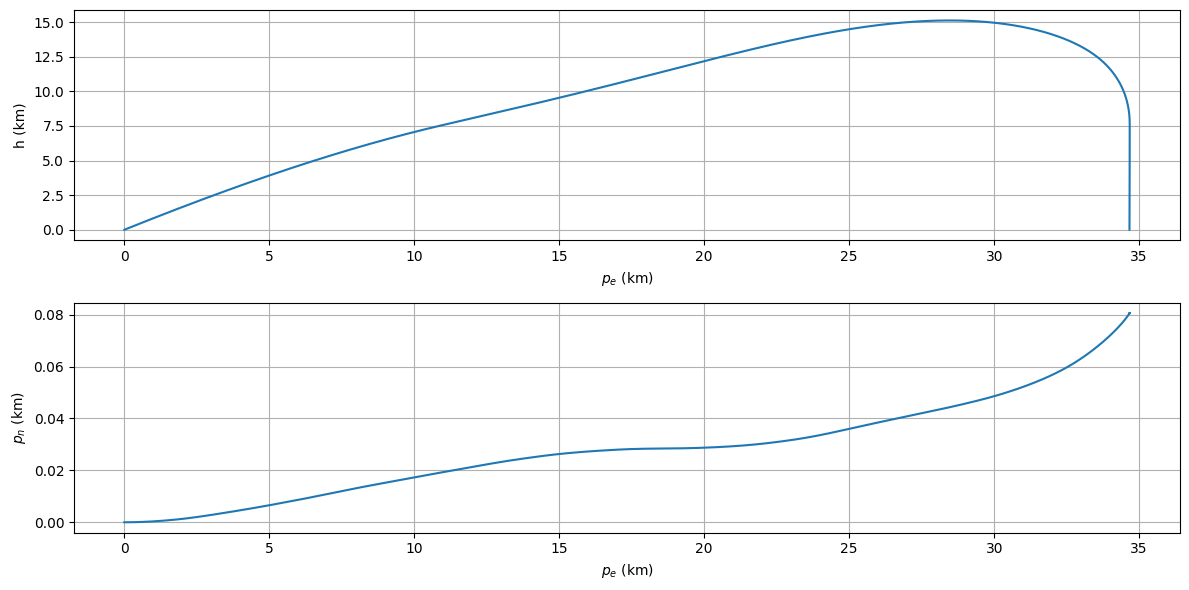

종말 속도: 437.15 m/s
종말 비행 경로각: -90.26 deg
비행거리: 34.67 km


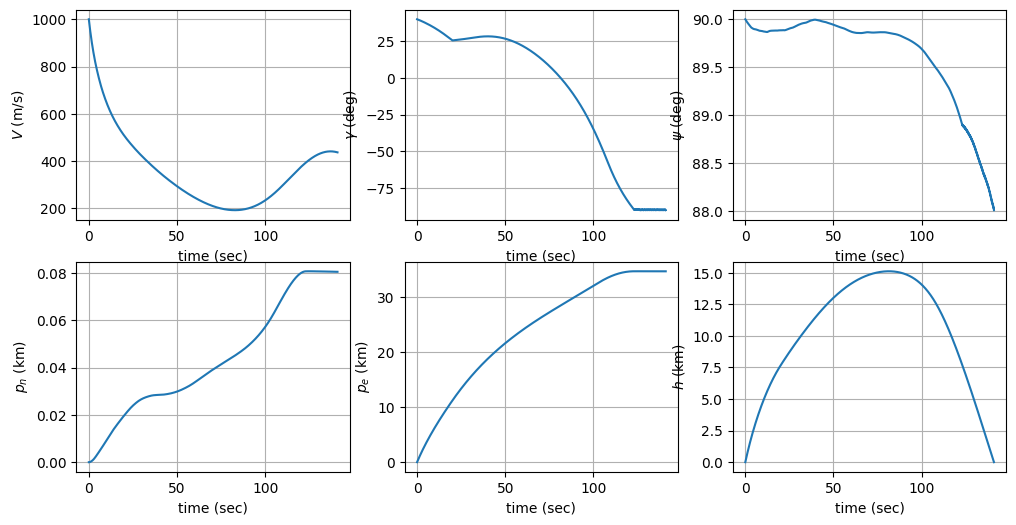

In [99]:
# initialize time
t = np.arange(0, tf, dt)  # time (tentative)
N = len(t)                # number of time steps

# initial wind
v_w = 5*np.random.randn(3)
v_w[-1] = 0

# numerical integration
state = np.zeros((N,len(init)))
state[0] = init
u = compute_guidance_cmd(t[0],state[0],p_target,v_target)
deriv_p = state_derivative(state[0],v_w,u)
for k in range(N-1):
  u = compute_guidance_cmd(t[k],state[k],p_target,v_target)
  deriv = state_derivative(state[k],v_w,u)
  state[k+1] = state[k] + dt*(3*deriv - deriv_p)/2
  v_w[0] += np.random.randn()
  v_w[1] += np.random.randn()
  deriv_p = deriv
  if state[k,-1]<0:       # termination condition
    break;                # break if the last state variable (h) is negative

# solution
t_s = t[:k+1]             # time
state = state[:k+1]       # state history

# plot
fig, ax = plt.subplots(2,1, figsize=(12,6), dpi=100)
ax[0].plot(state[:,4]/1000, state[:,5]/1000)
ax[0].set_xlabel(r'$p_e$ (km)')
ax[0].set_ylabel(r'h (km)')
ax[0].grid()
ax[1].plot(state[:,4]/1000, state[:,3]/1000)
ax[1].set_xlabel(r'$p_e$ (km)')
ax[1].set_ylabel(r'$p_n$ (km)')
ax[1].grid()
plt.tight_layout()
plt.show()

print(f'종말 속도: {state[-1,0]:.2f} m/s')
print(f'종말 비행 경로각: {state[-1,1]*Rad2Deg:.2f} deg')
print(f'비행거리: {state[-1,4]/1000:.2f} km')

plt.figure(figsize=(12,6), dpi=100)
plt.subplot(2,3,1)
plt.plot(t_s, state[:,0])
plt.xlabel(r'time (sec)')
plt.ylabel(r'$V$ (m/s)')
plt.grid()
plt.subplot(2,3,2)
plt.plot(t_s, state[:,1]*180/np.pi)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$\gamma$ (deg)')
plt.grid()
plt.subplot(2,3,3)
plt.plot(t_s, state[:,2]*180/np.pi)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$\psi$ (deg)')
plt.grid()
plt.subplot(2,3,4)
plt.plot(t_s, state[:,3]/1000)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$p_n$ (km)')
plt.grid()
plt.subplot(2,3,5)
plt.plot(t_s, state[:,4]/1000)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$p_e$ (km)')
plt.grid()
plt.subplot(2,3,6)
plt.plot(t_s, state[:,5]/1000)
plt.xlabel(r'time (sec)')
plt.ylabel(r'$h$ (km)')
plt.grid()
plt.show()

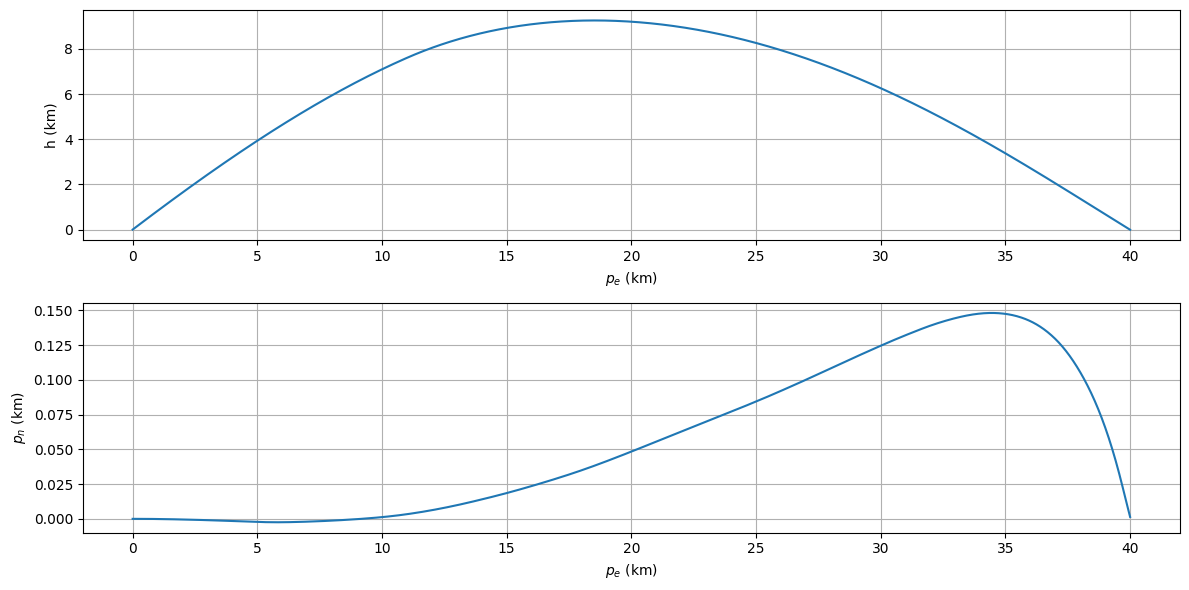

종말 속도: 332.33 m/s
종말 비행 경로각: -34.37 deg
비행거리: 40.01 km
탄착점(N): 0.0013 km
탄착점(E): 40.0103 km


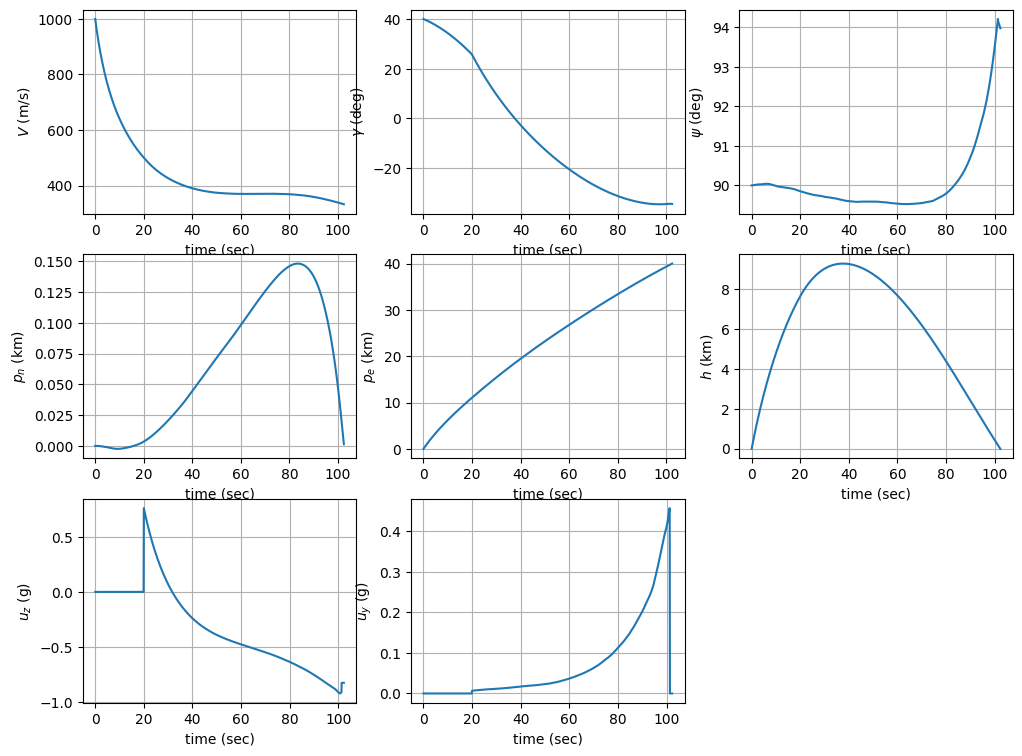

In [ ]:
##################
# your code here #


# your code here #
##################

<br>

_**(Problem 4)**_
2000회 Monte-Carlo 시뮬레이션을 수행하고, 2000개의 궤적을 모두 한 평면에 도시하시오.


In [ ]:
# integration parameters
tf = 200                  # final time
dt = 0.1                  # step size
t = np.arange(0, tf, dt)  # time (tentative)
N = len(t)                # number of time steps

# initial conditions
V = 1000.0                # velocity
gamma = 40*Deg2Rad        # flight path angle
psi = 90*Deg2Rad          # heading
pn, pe, h = np.zeros(3)   # position
init = [V, gamma, psi, pn, pe, h]

# Monte-Carlo simulation parameter
n_mc = 2000               # number of Monte-Carlo runs


   100   200   300   400   500   600   700   800   900  1000
  1100  1200  1300  1400  1500  1600  1700  1800  1900  2000

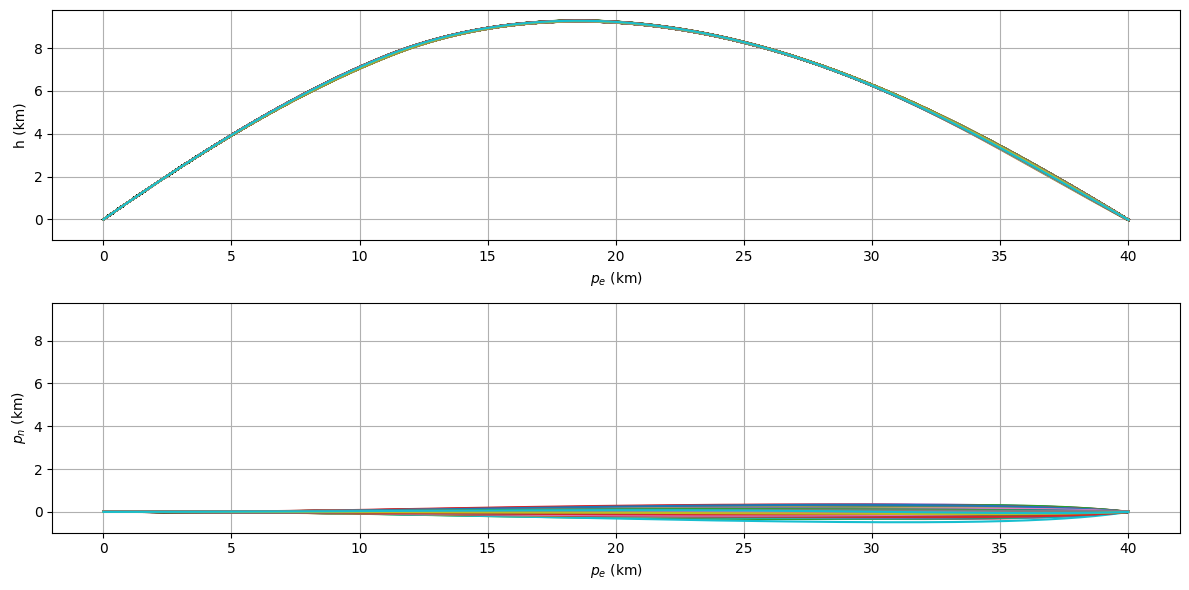

In [ ]:
##################
# your code here #


# your code here #
##################

<br>

_**(Problem 4)**_ 2000번 시뮬레이션 결과 탄착점의 위치를 `matplotlib.pyplot`의 `scatter` 함수를 사용하여 NE 평면 위에 도시하고, 표적과 평균 탄착점의 위치도 함께 도시하시오.

유도로켓의 탄착 정밀도는 보통 CEP(Circular Error Probable, 원형공산오차)로 표현하며, CEP는 표적 중심으로 50%의 확률로 탄착할 수 있는 원의 반경으로 정의된다. 즉, 어떤 유도로켓의 CEP가 200m라면 이 로켓을 100번 날렸을 때 50번 정도가 표적 중심 반경 200m이내에 탄착함을 의미한다.

위의 계산 결과를 이용하여 이 유도로켓의 CEP를 추산하시오.

CEP: 0.0012 km


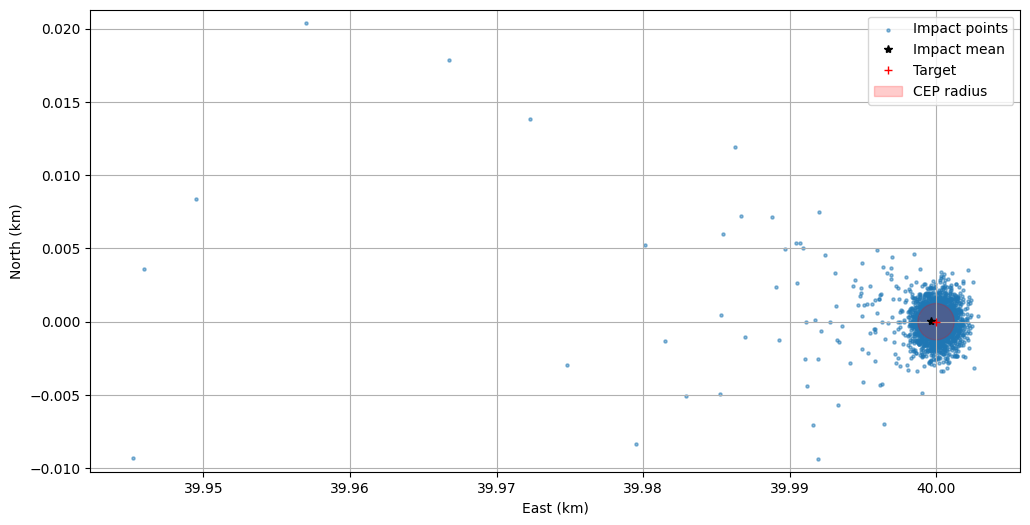

In [ ]:
##################
# your code here #


# your code here #
##################